## Notebook 01

Welcome! Today we are making a 'simple' Convolutional-Neural-Network (CNN). Basically it reads in images, and has 2D layers before feeding into fully-connected layers. 

This should hopefully be self-contained, but it requires a bit of understanding. IE this is not from first principles, and I encourage someone reading this to pick up a textbook instead of learning from my notebook. 

Good luck. 

In [1]:
# Imports and global parameters
# we are going to define the hyper-paramters (the model architecture, and training later)
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import time
import numpy as np
from sklearn.metrics import confusion_matrix
import pandas as pd
from torch.utils.data import TensorDataset, DataLoader, random_split


# change this on your computer
data_dir = '/home/afinemax/data/machine_learning/mnist/'
train_csv = data_dir + 'train.csv' # Using the Kaggle version now
test_csv = data_dir + 'test.csv'

# Device
# Checks if there is a gpu, if not uses the CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


## Load in the data

In Machine Learning problems you **always** want to read in, and then plot your data so you know what it looks like. Here, we already know what **MNIST** looks like. So we go out of order. 

After we plot the data, we want to re-normalize it, this typically means setting the mean/median to 1, and setting the std to 1. This is easier for machine learning applications, other rescallings are possible. **Important** - you want to do your re-normalization using information from only the "train" set of data, if you use all of it / also the "test" we are introducing information that we are not supposed to know of during the training!.  This is known as pre-processing, but you can do fancier things as well. 

We typically also split the data into train/test with 80/20 or 90/20 ratios, but MNIST is already split for us. 



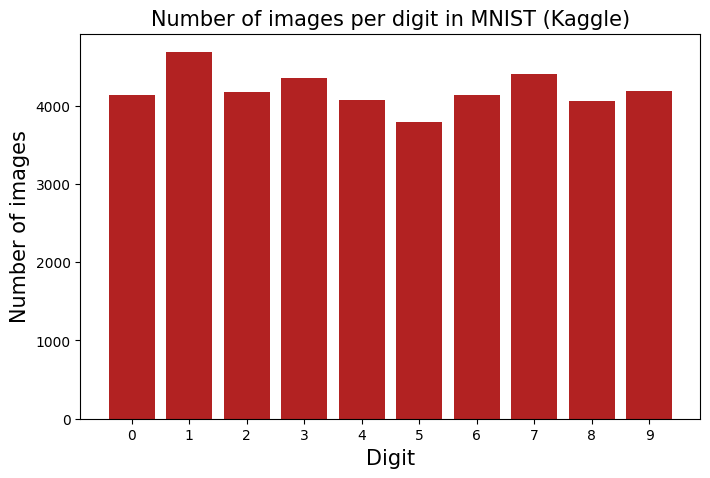

Training set Mean: 0.13083085417747498
Training set Std: 0.30836090445518494


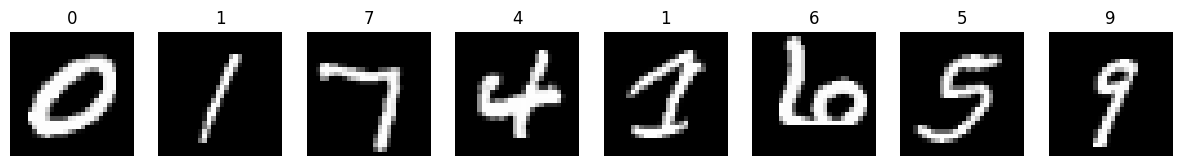

images shape: torch.Size([42000, 1, 28, 28])
42000 = number of images
1 = number of channels (MNIST is grayscale)
28 x 28 = image height and width


In [7]:
# Load CSVs
train_df = pd.read_csv(train_csv)
test_df  = pd.read_csv(test_csv)

# Display the training data
digit_counts = train_df['label'].value_counts().sort_index()
plt.figure(figsize=(8,5))
plt.bar(digit_counts.index, digit_counts.values, color='firebrick')
plt.xlabel('Digit', size=15)
plt.ylabel('Number of images', size=15)
plt.title('Number of images per digit in MNIST (Kaggle)', size=15)
plt.xticks(range(10))
plt.show()

# Separate labels and pixels
train_labels = torch.tensor(train_df['label'].values, dtype=torch.long)
train_images = torch.tensor(train_df.drop(columns=['label']).values, dtype=torch.float32)

# MNIST images are 28x28
train_images = train_images.view(-1, 1, 28, 28) / 255.0  # scale [0,255] -> [0,1]

# Create full dataset (unnormalized)
full_dataset = TensorDataset(train_images, train_labels)

# Split into 80% train, 20% eval
train_size = int(0.8 * len(full_dataset))
eval_size  = len(full_dataset) - train_size
train_dataset, eval_dataset = random_split(full_dataset, [train_size, eval_size])

# Compute mean and std from training images only
train_images_only = torch.stack([img for img, _ in train_dataset])
mean = train_images_only.mean()
std  = train_images_only.std()
print("Training set Mean:", mean.item())
print("Training set Std:", std.item())

# Define normalization transform
normalize = transforms.Normalize((mean.item(),), (std.item(),))

# Apply normalization to train dataset
train_images_norm = torch.stack([normalize(img) for img, _ in train_dataset])
train_labels_tensor = torch.tensor([lbl for _, lbl in train_dataset], dtype=torch.long)
train_dataset = TensorDataset(train_images_norm, train_labels_tensor)

# Apply normalization to eval dataset
eval_images_norm = torch.stack([normalize(img) for img, _ in eval_dataset])
eval_labels_tensor = torch.tensor([lbl for _, lbl in eval_dataset], dtype=torch.long)
eval_dataset = TensorDataset(eval_images_norm, eval_labels_tensor)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
eval_loader  = DataLoader(eval_dataset, batch_size=8, shuffle=False)

# Prepare test dataset and loader
test_images = torch.tensor(test_df.values, dtype=torch.float32)
test_images = test_images.view(-1, 1, 28, 28) / 255.0
test_images_norm = torch.stack([normalize(img) for img in test_images])
test_dataset = TensorDataset(test_images_norm)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)


# Visualize some training examples
images, labels = next(iter(train_loader))
fig, axes = plt.subplots(1, 8, figsize=(15, 3))
for i in range(8):
    img = images[i].squeeze() * std + mean  # undo normalization
    axes[i].imshow(img, cmap='gray')
    axes[i].set_title(labels[i].item())
    axes[i].axis("off")
plt.show()

# Dynamic print statement
print(
f'images shape: {train_images.shape}\n'
f'{train_images.shape[0]} = number of images\n'
f'{train_images.shape[1]} = number of channels (MNIST is grayscale)\n'
f'{train_images.shape[2]} x {train_images.shape[3]} = image height and width'
)


## We can see that there are ~ the same number of samples per Digit (class)

We are using 20% as the eval set, the test set is something we upload to kaggle!

## Defining our Model Architecture

Only now, after plotting the data, do we consider what type of model architecture to employ.

We are doing a fairly simple convolutional neural network (CNN) with **3 convolutional layers**, each with **10 filters**.

```python
self.conv1 = nn.Conv2d(1, 10, kernel_size=3, padding=1)
self.conv2 = nn.Conv2d(10, 10, kernel_size=3, padding=1)
self.conv3 = nn.Conv2d(10, 10, kernel_size=3, padding=1)
```

* **Conv2d explanation:**

  * `in_channels` = number of channels in the input image (here 1 for grayscale).
  * `out_channels` = number of filters the layer learns (here 10).
  * `kernel_size` = size of the convolutional filter (3×3 here), which slides over the input to extract features.
  * `padding=1` ensures the output feature map has the same height and width as the input.

* **Input/Output shapes:**

  1. `conv1`: Input `(batch_size, 1, 28, 28)` → Output `(batch_size, 10, 28, 28)`
  2. `conv2`: Input `(batch_size, 10, 14, 14)` → Output `(batch_size, 10, 14, 14)`
  3. `conv3`: Input `(batch_size, 10, 7, 7)` → Output `(batch_size, 10, 7, 7)`

After each convolution, we apply **ReLU activation** to introduce non-linearity.

### ReLU Activation Function

* ReLU (Rectified Linear Unit) is defined as `ReLU(x) = max(0, x)`.
* It keeps positive values and sets negative values to zero.
* Introduces non-linearity, helps with vanishing gradient problems, and is computationally efficient.

### Max Pooling Layer

```python
self.pool = nn.MaxPool2d(2, 2)
```

* **What MaxPool does:**

  * Reduces the spatial dimensions of the feature map by taking the **maximum value** in each 2×2 window.
  * Helps reduce computation, memory, and overfitting.
  * Each pooling layer halves the width and height of the feature map.

* **Input/Output shapes after pooling:**

  1. After first pool: `(28, 28)` → `(14, 14)`
  2. After second pool: `(14, 14)` → `(7, 7)`

### Fully Connected Layers (Multi-Layer Perceptron)

After the convolution and pooling layers, we **flatten** the 3D feature maps into a 1D vector:

```python
x = x.view(-1, 10*7*7)
```

* This vector is then passed through **fully connected layers**, which are just **linear transformations**:

```python
self.fc1 = nn.Linear(10*7*7, 32)  # first hidden layer
self.fc2 = nn.Linear(32, 16)      # second hidden layer
self.fc3 = nn.Linear(16, 10)      # output layer
```

* **Fully connected layer:**

  * Each neuron is connected to **every input feature** from the previous layer.
  * Learns combinations of features to make predictions.

* **Input/Output shapes:**

  1. `fc1`: Input `(batch_size, 10*7*7)` → Output `(batch_size, 32)`
  2. `fc2`: Input `(batch_size, 32)` → Output `(batch_size, 16)`
  3. `fc3`: Input `(batch_size, 16)` → Output `(batch_size, 10)`

### Calculating Number of Parameters

* **Convolutional layer:**
  Parameters = `(kernel_height * kernel_width * in_channels) * out_channels + out_channels (bias)`

  * Example `conv1`: `(3*3*1)*10 + 10 = 100`

* **Fully connected layer:**
  Parameters = `(input_features * output_features) + output_features (bias)`

  * Example `fc1`: `490*32 + 32 = 15712`

| Layer | Input shape | Output shape | Parameters |
| ----- | ----------- | ------------ | ---------- |
| conv1 | (1,28,28)   | (10,28,28)   | 100        |
| conv2 | (10,14,14)  | (10,14,14)   | 910        |
| conv3 | (10,7,7)    | (10,7,7)     | 910        |
| fc1   | 490         | 32           | 15712      |
| fc2   | 32          | 16           | 528        |
| fc3   | 16          | 10           | 170        |

### Final Output

* The **output vector** has size `n_classes = 10` (for MNIST digits).
* Each value represents the **score or probability** of that class.
* The predicted class is simply the one with the **highest probability**.


In [4]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        # 3 convolutional layers (10 filters each)
        self.conv1 = nn.Conv2d(1, 10, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(10, 10, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(10, 10, kernel_size=3, padding=1)
        
        self.pool = nn.MaxPool2d(2, 2)
        
        # Fully connected layers (small)
        self.fc1 = nn.Linear(10 * 7 * 7, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        
        x = F.relu(self.conv3(x))
        
        x = x.view(-1, 10 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x

# Now we send our model to the GPU/CPU
model = CNN().to(device)
print(model)


CNN(
  (conv1): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=490, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=10, bias=True)
)


## Training Parameters

Choosing our model hyper-paramters is not the end of selecting values!

We also need to set:

- `epochs`: number of times the training set is looped over, you want to train but not over fit
- `lr` : "learning rate" - Controls how much the model's weights are updated during each optimization step. Smaller values make training slower but more stable. We multiply this by the gradient descent or other optimizer. 
- `criterion`: The loss function. Measures how well the model's predictions match the true labels. CrossEntropyLoss is commonly used for multi-class classification.

- `optimizer = optim.Adam(model.parameters(), lr=lr)`
The optimization algorithm. Adam updates the model's weights based on the gradients computed from the loss. It combines ideas from momentum and adaptive learning rates for faster and more stable convergence.

There are many optimizers, most are based on the idea of gradient descent, and several criterions. It is common to define your own, the criterion is also known as the loss-function, so the reduced chi square could be a criterion. You can also use a dynamic `lr` to change size as the number of epochs or change in the loss changes. 

In [5]:

epochs = 10
lr = 0.001 
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

Epoch [1/10] - Loss: 0.2881 - Duration: 7.36 seconds
Epoch [2/10] - Loss: 0.0991 - Duration: 7.72 seconds
Epoch [3/10] - Loss: 0.0708 - Duration: 5.87 seconds
Epoch [4/10] - Loss: 0.0553 - Duration: 7.21 seconds
Epoch [5/10] - Loss: 0.0470 - Duration: 7.24 seconds
Epoch [6/10] - Loss: 0.0417 - Duration: 7.13 seconds
Epoch [7/10] - Loss: 0.0355 - Duration: 6.69 seconds
Epoch [8/10] - Loss: 0.0316 - Duration: 7.58 seconds
Epoch [9/10] - Loss: 0.0301 - Duration: 8.11 seconds
Epoch [10/10] - Loss: 0.0249 - Duration: 7.25 seconds


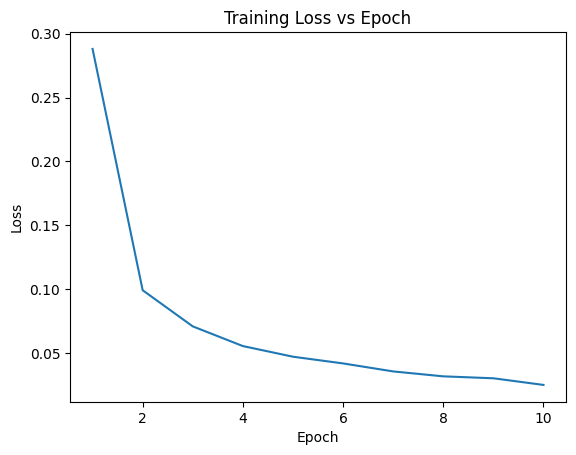

In [6]:

epoch_losses = []
epoch_durations = []

for epoch in range(epochs):
    start_time = time.time()
    
    model.train()
    running_loss = 0.0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    avg_loss = running_loss / len(train_loader)
    epoch_time = time.time() - start_time
    
    epoch_losses.append(avg_loss)
    epoch_durations.append(epoch_time)
    
    print(f"Epoch [{epoch+1}/{epochs}] "
          f"- Loss: {avg_loss:.4f} "
          f"- Duration: {epoch_time:.2f} seconds")

# Plot Epoch vs Loss
plt.figure()
plt.plot(range(1, epochs+1), epoch_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss vs Epoch")
plt.show()


## The above plot is known as the ''learning curve''

Models at first learn a lot, but then start to platue and bob up and down due to random noise, training after hitting the platue does not help, it might even hurt by over-fitting the data

## Lets see how our model did

We load in the `test` set, and measure the accuracy, and then plot the confusion matrix to look for any "hard categories"

In [8]:
model.eval()

correct = 0
total = 0

with torch.no_grad():
    for images, labels in eval_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)              # forward pass
        _, predicted = torch.max(outputs, 1) # predicted class index

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")


Test Accuracy: 98.89%


Digit : Number of incorrect predictions
0 : 1
1 : 3
2 : 3
3 : 9
4 : 8
5 : 17
6 : 5
7 : 22
8 : 7
9 : 18


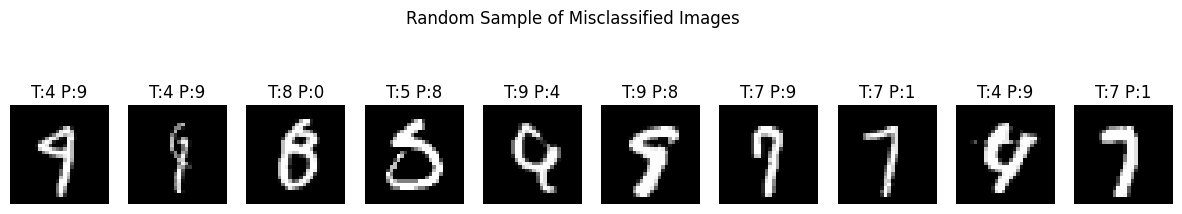

In [16]:

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in eval_loader:
        images = images.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy())  # <-- predictions
        all_labels.extend(labels.numpy())          # <-- true labels


all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# 1 Print number of incorrect predictions per digit
print("Digit : Number of incorrect predictions")
for digit in range(10):
    incorrect_mask = (all_labels == digit) & (all_preds != digit)
    num_incorrect = incorrect_mask.sum()
    print(f"{digit} : {num_incorrect}")

# 2 Collect all misclassified indices
misclassified_mask = all_labels != all_preds
misclassified_indices = np.where(misclassified_mask)[0]

# Randomly pick up to 10 misclassified examples
num_to_show = min(10, len(misclassified_indices))
sample_indices = np.random.choice(misclassified_indices, num_to_show, replace=False)

# Flatten eval_loader batches for easy indexing
images_list = []
for images, _ in eval_loader:
    images_list.append(images)
images_all = torch.cat(images_list, dim=0)

# Plot sampled misclassified images
plt.figure(figsize=(15, 3))
for i, idx in enumerate(sample_indices):
    plt.subplot(1, num_to_show, i+1)
    plt.imshow(images_all[idx].cpu().squeeze(), cmap='gray')
    plt.title(f"T:{all_labels[idx]} P:{all_preds[idx]}")
    plt.axis('off')
plt.suptitle("Random Sample of Misclassified Images")
plt.show()


Some people write their 9's like 4's, and lets see our predictions. 

In [13]:

#Kaggle prediction setup example

predictions = []
model.eval()
with torch.no_grad():
    for batch in test_loader:
        imgs = batch[0]  # test_loader returns a tuple
        outputs = model(imgs)
        preds = outputs.argmax(dim=1)
        predictions.extend(preds.cpu().numpy())

# Create Kaggle submission CSV
submission_df = pd.DataFrame({
    "ImageId": range(1, len(predictions)+1),
    "Label": predictions
})
submission_df.to_csv("model1_submission.csv", index=False)